# YouTube Comment Analysis

We will analyse YouTube video comments using various methods:

- investigate the donations for a video
- sentiment analysis using `TextBlob` and `VaderSentiment`
- estimation of the dislikes on a video based on the comment polarity and the likes
- extract the relevant terms of highly positive and negative comments using TF-IDF

Preparatory steps:

1. open a YouTube video in the Browser
2. inspect the page
3. copy the HTML `body` element
4. paste the element to `html_body.txt`

Note: if there are numerous comments on a video, it is recommended to scroll down a couple of times to get a representative overview of the comments before extracting the HTML.

## General Imports

In [44]:
import json
import nltk
import pandas as pd
import random
import re
import seaborn as sns
import string

from bs4 import BeautifulSoup
from googletrans import Translator
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from typing import List, Dict
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Parse HTML using BeautifulSoup

In [45]:
with open('./html_body.txt', 'r', encoding='utf-8') as file:
    raw_html = file.read()

In [46]:
soup = BeautifulSoup(raw_html)

## Donations

Scrape donations from the parsed HTML via the `comment-chip-price` spans.

In [47]:
price_spans = soup.findAll('span', {'id': 'comment-chip-price'})

In [48]:
donations = [elem.text.strip() for elem in price_spans if len(elem.text.strip()) > 0]

In [49]:
donation_df = pd.DataFrame([elem.split("\xa0") for elem in donations], 
                           columns=['donation', 'currency'])

In [50]:
donation_df.dtypes

donation    object
currency    object
dtype: object

In [51]:
donation_df['donation'] = donation_df['donation'].apply(lambda donation: donation.replace(',', '.')).astype(float)

Some donations are non-euro - provide conversion table here.

In [52]:
curr_conv_df = pd.DataFrame([["CHF", 1.07], ["€", 1.00]], columns=['currency', 'factor'])

In [53]:
curr_conv_df.dtypes

currency     object
factor      float64
dtype: object

In [54]:
merge = donation_df.merge(curr_conv_df, left_on='currency', right_on='currency', how='left')

### Summary of Donations

In [55]:
merge['conv_donation'] = merge['donation'] * merge['factor']

In [56]:
print(f"Total sum of donations: EUR {merge['conv_donation'].sum():.2f}")

Total sum of donations: EUR 1633.09


In [57]:
sns.set(font_scale=1.3)

Text(0.5, 1.0, 'Donations')

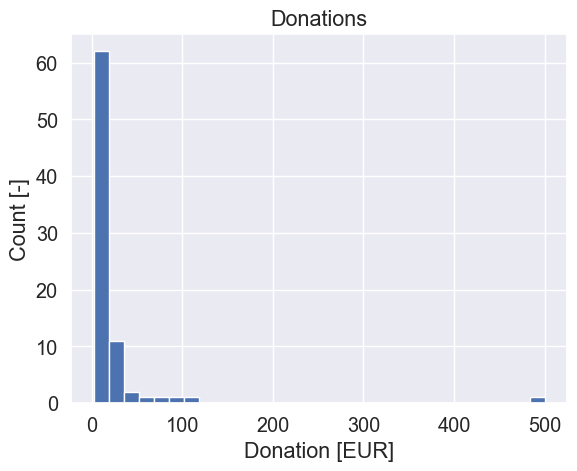

In [58]:
merge['conv_donation'].hist(bins=30)
plt.xlabel('Donation [EUR]')
plt.ylabel('Count [-]')
plt.title('Donations')

## Sentiment Analysis

Depending on the scraped comments, sentiment extraction may require German corpora and the `textblob-de` package.

Here, we use `googletrans` to directly translate the comments to english (if required) and then perform sentiment analysis on these translations using `textblob`.

### Comment Extraction

In [59]:
# comments are located within the "contents" div
content_divs = soup.find('div', {'id': 'contents', 
                                 'class': 'style-scope ytd-item-section-renderer style-scope ytd-item-section-renderer'})

In [60]:
comment_spans = content_divs.findAll('span', {'role': 'text'})

In [61]:
comments = [comment.text.strip() for comment in comment_spans if 'Antwort' not in comment.text.strip()]

In [62]:
comments[:3]

['Diese Kommentarsektion ist nun Eigentum der BRD.',
 'Ein Bewegtbildmeisterwerk in Spielfilmlänge',
 '5 Monate.. Das warten hat ein Ende. DANKE JULES']

In [63]:
len(comments)

225

### Comment Translation

In [64]:
translator = Translator()

#### Test translation

In [65]:
translator.translate(comments[0], dest='en').text

'This comment section is now the property of the FRG.'

#### Concatenation of Comments, Translation, and Split

The Google API has rate limits; we concatenate the data into chunks of up to 3000 characters and then translate each chunk in one go, followed by splitting into individual comments.

In [66]:
separator: str = " ||| "

In [67]:
def concatenate_comments_with_limit(comments: List[str],
                                    separator: str = " ||| ", 
                                    max_length: int = 3000) -> List[str]:
    """
    Concatenates a list of comments into larger strings, each with a maximum length limit. 
    When the concatenated string exceeds the max_length, the last comment is removed, 
    and a new concatenation starts.

    :param comments: List of text comments to be concatenated.
    :param separator: A string used to separate comments in the concatenated string. Default is ' ||| '.
    :param max_length: The maximum allowed length for each concatenated string. Default is 3000 characters. 
        Note: if higher numbers are chosen, translation requests may fail.
    :return: A list of concatenated strings where each string's length does not exceed the max_length.
    """
    concatenated_strings = []
    current_concat = ""

    for comment in comments:
        # add the separator only if current_concat is not empty
        next_concat = current_concat + (separator if current_concat else "") + comment
        
        # check if adding the next comment would exceed the max_length
        if len(next_concat) > max_length:
            # append the current concatenated string (without the new comment)
            concatenated_strings.append(current_concat)
            # start a new concatenated string with the current comment
            current_concat = comment
        else:
            # update the current concatenated string
            current_concat = next_concat

    # append the last concatenated string if it's not empty
    if current_concat:
        concatenated_strings.append(current_concat)

    return concatenated_strings

In [68]:
concatenates = concatenate_comments_with_limit(comments=comments,
                                               separator=separator)

#### Translation via Google Translate

In [69]:
from tqdm import tqdm

In [70]:
raw_translations = []
for i, concatenate in tqdm(
    enumerate(concatenates), 
    total=len(concatenates), 
    desc='Translating comment concatenates'
):
    try:
        raw_translations.append(translator.translate(concatenate, dest='en'))
    except Exception as e:
        print(f"Error translating chunk {i}: {type(e)}: {e}")
        print(concatenate)

Translating comment concatenates: 100%|████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.45s/it]


In [71]:
combined_translations = separator.join([translation.text for translation in raw_translations])

In [72]:
combined_translations[:100]

'This comment section is now the property of the FRG.|||A moving masterpiece in feature film length |'

In [73]:
len(combined_translations)

30654

In [74]:
translated_comments = combined_translations.split("|||")

In [75]:
translated_comments[:3]

['This comment section is now the property of the FRG.',
 'A moving masterpiece in feature film length ',
 '5 months .. The wait has an end.Thanks Jules ']

### Sentiment Extraction

Based on the translated comments, we now extract sentiments via the `VaderSentiment` and `TextBlob` packages.

Conceptual difference: VADER (Valence Aware Dictionary and sEntiment Reasoner) is designed specifically for social media sentiments (e.g., regarding processing of emoticons and exclamatory expressions), whereas TextBlob is a general purpose tool. VADER classifies the text in proportions of negative and positive elements and a compound score, whereas TextBlob only provides a polarity score and an estimate of subjectivity. Both approaches are lexicon-based, but TextBlob additionally incorporates an NaiveBayes classifier.

In [76]:
vader_analyzer = SentimentIntensityAnalyzer()

In [77]:
comment_df = pd.DataFrame(
    {
        'translation': translated_comments,
        'polarity_textblob': [TextBlob(comment).sentiment.polarity for comment in translated_comments],
        'polarity_vader': [vader_analyzer.polarity_scores(comment)['compound'] for comment in translated_comments]
    }
)

For a polarity > 0, the extracted sentiment is positive, for < 0 negative, else neutral.

In [78]:
for suffix in ['textblob', 'vader']:
    comment_df[f'sentiment_{suffix}'] = comment_df[f'polarity_{suffix}'].apply(
        lambda pol: 'positive' if pol > 0 else 'negative' if pol < 0 else 'neutral'
    )

In [79]:
comment_df

,translation,polarity_textblob,polarity_vader,sentiment_textblob,sentiment_vader
0,This comment section is now the property of th...,0.000000,0.0000,neutral,neutral
1,A moving masterpiece in feature film length,0.000000,0.6249,neutral,positive
2,5 months .. The wait has an end.Thanks Jules,0.000000,0.0000,neutral,neutral
3,Just wow.I now know 2 of your blockbusters (wh...,-0.484375,0.5298,negative,positive
4,"""Nowadays there are no more good films!""\n\nJu...",0.375000,0.1494,positive,positive
...,...,...,...,...,...
216,Probably the best video on YouTube,1.000000,0.6369,positive,positive
217,Jules should release the video on VHS so that ...,-0.400000,0.0000,negative,neutral
218,Hammer video a bit speechless and I (as always...,0.000000,0.5267,neutral,positive
219,Thanks!,0.250000,0.4926,positive,positive


#### Isolation of problematic cases

To investigate the feasibility of our analysis, we check for internal consistency by counting the cases where both polarity analyses diverge strongly.

We will do so in two ways:

1. extraction of cases where one analysis yielded a positive and one analysis yielded a negative polarity
2. extraction of cases where the extracted polarities differ by 0.5

In [80]:
positive_vs_negative_comments = comment_df.query(
    '(polarity_textblob > 0.2 & polarity_vader < -0.2) | (polarity_textblob < -0.2 & polarity_vader > 0.2)'
)

In [81]:
positive_vs_negative_comments

,translation,polarity_textblob,polarity_vader,sentiment_textblob,sentiment_vader
3,Just wow.I now know 2 of your blockbusters (wh...,-0.484375,0.5298,negative,positive
196,How surprisingly serious it was in the end ...,-0.333333,0.2263,negative,positive


In [82]:
print(f"{len(positive_vs_negative_comments)} cases ({len(positive_vs_negative_comments)/len(comment_df):.1%}) where analyses yielded opposite sentiment.")

2 cases (0.9%) where analyses yielded opposite sentiment.


In [83]:
absolute_polarity_divergence_comments = comment_df.query(
    '(polarity_textblob - polarity_vader < -0.5) | (polarity_textblob - polarity_vader > 0.5)'
)

In [84]:
absolute_polarity_divergence_comments

,translation,polarity_textblob,polarity_vader,sentiment_textblob,sentiment_vader
1,A moving masterpiece in feature film length,0.000000,0.6249,neutral,positive
3,Just wow.I now know 2 of your blockbusters (wh...,-0.484375,0.5298,negative,positive
8,"""No criticism is praise enough"" says in German...",0.200000,0.7717,positive,positive
15,"Not Even German here, in the Learning German C...",-0.120000,0.8288,negative,positive
18,After so many hours of such a delicious entert...,0.196000,0.9311,positive,positive
...,...,...,...,...,...
210,I am BJ 69 and today got this tip for the vide...,0.400347,0.9765,positive,positive
212,"Boy Oh boy, where should I start.Jules ... hon...",0.348864,0.9644,positive,positive
215,Jules videos are the only ones for which I nee...,0.090000,0.7135,positive,positive
218,Hammer video a bit speechless and I (as always...,0.000000,0.5267,neutral,positive


In [85]:
print(f"{len(absolute_polarity_divergence_comments)} cases ({len(absolute_polarity_divergence_comments)/len(comment_df):.1%}) where analyses yielded a delta of 0.5 for the polarity.")

72 cases (32.6%) where analyses yielded a delta of 0.5 for the polarity.


#### Sentiment Visualisation

In [86]:
sns.set()

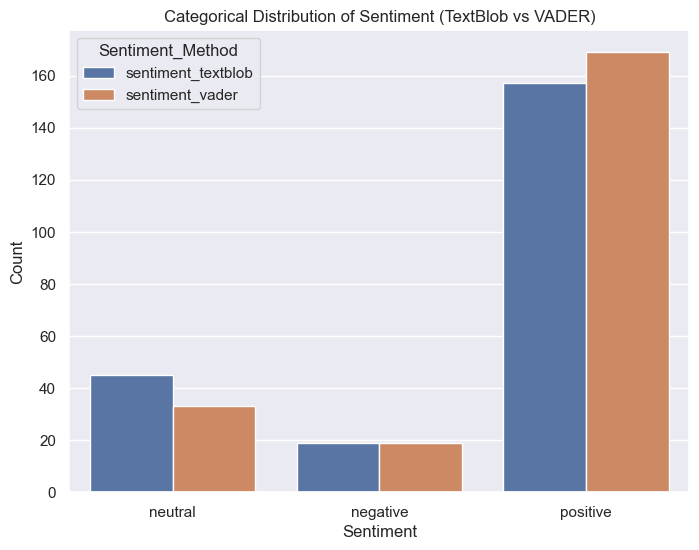

In [87]:
# melt the DF so we can plot both columns as categorical variables in the same plot
df_melted = comment_df.melt(value_vars=['sentiment_textblob', 'sentiment_vader'], 
                            var_name='Sentiment_Method', 
                            value_name='Sentiment')

# plot using matplotlib / seaborn
plt.figure(figsize=(8, 6))

sns.countplot(x='Sentiment', 
              hue='Sentiment_Method', 
              data=df_melted, 
              dodge=True)

plt.title('Categorical Distribution of Sentiment (TextBlob vs VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [90]:
comment_df

,translation,polarity_textblob,polarity_vader,sentiment_textblob,sentiment_vader
0,This comment section is now the property of th...,0.000000,0.0000,neutral,neutral
1,A moving masterpiece in feature film length,0.000000,0.6249,neutral,positive
2,5 months .. The wait has an end.Thanks Jules,0.000000,0.0000,neutral,neutral
3,Just wow.I now know 2 of your blockbusters (wh...,-0.484375,0.5298,negative,positive
4,"""Nowadays there are no more good films!""\n\nJu...",0.375000,0.1494,positive,positive
...,...,...,...,...,...
216,Probably the best video on YouTube,1.000000,0.6369,positive,positive
217,Jules should release the video on VHS so that ...,-0.400000,0.0000,negative,neutral
218,Hammer video a bit speechless and I (as always...,0.000000,0.5267,neutral,positive
219,Thanks!,0.250000,0.4926,positive,positive


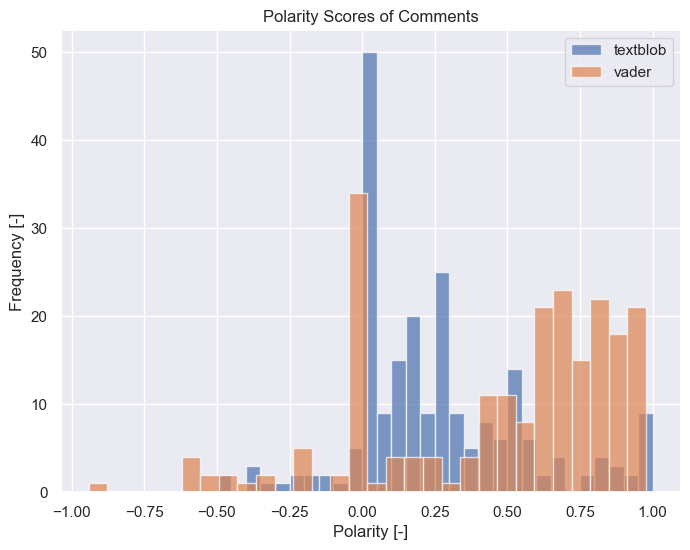

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))
comment_df['polarity_textblob'].hist(bins=30, ax=ax, label='textblob', alpha=0.7)
comment_df['polarity_vader'].hist(bins=30, ax=ax, label='vader', alpha=0.7)
plt.title('Polarity Scores of Comments')
plt.xlabel('Polarity [-]')
plt.ylabel('Frequency [-]')
plt.legend()
plt.show()

If shifted to the right, overall sentiment is positive, if shifted to left, negative, if Gaussian, neutral.

## Dislike Estimation

We estimate the number of dislikes on the video based on overall polarity of the comments, assuming that the ratio of positive to negative comments roughly corresponds to the number of likes to dislikes.

### Overall Comment Polarity Counts

We assume that only very positive and very negative comments based on the mean of VADER and TextBlob polarity result in a like or dislike.

Let's define an absolute polarity cut-off for this purpose.

In [92]:
polarity_cutoff = 0.5

Mean of the polarity scores from the two different analysis methods:

In [93]:
comment_df['polarity_mean'] = (comment_df['polarity_vader'] + comment_df['polarity_textblob'])/ 2

In [94]:
highly_positive_count = (comment_df['polarity_mean'] > polarity_cutoff).astype(int).sum()

In [95]:
highly_negative_count = (comment_df['polarity_mean'] < -polarity_cutoff).astype(int).sum()

In [96]:
comment_ratio = highly_positive_count / highly_negative_count

In [97]:
print(f"Highly positive comments: {highly_positive_count}, highly negative comments: {highly_negative_count}, ratio positive/negative: {comment_ratio}")

Highly positive comments: 82, highly negative comments: 2, ratio positive/negative: 41.0


### Like Count

In [98]:
with open('html_body.txt', 'r', encoding='utf-8') as file:
    html = file.read()

In [99]:
like_divs = BeautifulSoup(html, 'html.parser').findAll('div', {'class': 'yt-spec-button-shape-next__button-text-content'})

In [100]:
like_divs = [int(div.text.replace('.', '')) for div in like_divs if re.match('^\d{1,3}(\.\d{3})*$',  # regex expression for multi-digit number with point
                                                                             div.text)]

In [101]:
like_count = like_divs[0]

In [102]:
like_count

314865

### Dislike Estimate

We will now estimate the dislikes based on the highly positive to negative comment ratio and the like count.

In [103]:
print(f"Likes: {like_count}")

Likes: 314865


In [104]:
print(f"Estimate of dislikes based on likes and comment polarity: {int(like_count / comment_ratio)}")

Estimate of dislikes based on likes and comment polarity: 7679


## Isolation of extreme polarity-related terms

We isolate relevant terms (in this case, adjectives) from the comments to see what is being critisized.

Method: Tf-Idf based on tokenized corpus. We'll work with the VADER polarity here as it is more suitable for social media content.

Tf-Idf works by extracting overall word counts (term frequency, TF) and isolating words that are common to just a fraction of the documents (inverse document frequency, IDF).

For preparation, we need to download stopwords and apply removal of them.

In [105]:
# make sure to download stopwords if you haven't
nltk.download('stopwords')

# load stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
def preprocess_text(text: str,
                    stop_words: List[str]) -> str:
    """
    Preprocess the text by stopword elimination, removal of punctuation, and tokenzation.

    :param text: input comment.
    :param stop_words: list of stop words to eliminate.

    :return: preprocessed string.
    """
    # lowercase
    text = text.lower()
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)
        

def extract_relevant_terms(comment_df: pd.DataFrame,
                           polarity_column: str = 'polarity_vader', 
                           polarity_threshold: float = 0.5, 
                           max_features: int = 100,
                           term_count: int = 10) -> Dict[str, pd.Series]:
    """
    Extracts relevant terms from positive and negative comments based on TF-IDF scores.

    :param comment_df: input DF with comments and polarity.
    :param polarity_column: column in which the polarity is stored.
    :param polarity_threshold: threshold for the polarity score to apply (defaults to 0.5).
    :param max_features: number of terms to keep based on TF-IDF scores (defaults to 100).
    :param term_count: number of terms to return.

    :return: returns top TF-IDF terms in a pd.Series for both positive and negative comments.
    """
    # filter out highly positive and highly negative comments
    positive_comments = comment_df[comment_df[polarity_column] > polarity_threshold]['translation']
    negative_comments = comment_df[comment_df[polarity_column] < -polarity_threshold]['translation']

    # apply preprocessing to comments
    positive_comments = positive_comments.apply(lambda comment: preprocess_text(comment,
                                                                                stop_words=stop_words))
    negative_comments = negative_comments.apply(lambda comment: preprocess_text(comment,
                                                                                stop_words=stop_words))

    # combine the two sets into one DataFrame for TF-IDF
    combined_df = pd.concat([positive_comments, negative_comments], axis=0)

    # define a binary label to keep track of positive (1) and negative (0) comments
    labels = [1] * len(positive_comments) + [0] * len(negative_comments)

    # initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 ngram_range=(1, 2))  # You can adjust max_features or n-grams

    # fit and transform the comments
    X = vectorizer.fit_transform(combined_df)

    # create a DataFrame from the TF-IDF matrix
    tfidf_df = pd.DataFrame(
        X.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )

    # separate TF-IDF scores for positive and negative comments
    tfidf_positive = tfidf_df.iloc[:len(positive_comments)].mean().sort_values(ascending=False)
    tfidf_negative = tfidf_df.iloc[len(positive_comments):].mean().sort_values(ascending=False)

    # return the top terms for positive and negative comments
    return {
        'positive': tfidf_positive.head(term_count),
        'negative': tfidf_negative.head(term_count)
    }

In [107]:
results = extract_relevant_terms(comment_df,
                                 term_count=10)

print("Top positive terms:\n")
print(results['positive'])

print("\nTop negative terms:\n")
print(results['negative'])

Top positive terms:

video          0.106238
masterpiece    0.072623
jules          0.070993
best           0.068220
thank          0.062431
videos         0.048938
germany        0.045382
much           0.042285
good           0.036553
youtube        0.036349
dtype: float64

Top negative terms:

german      0.156187
exactly     0.115993
absolute    0.111086
even        0.109929
im          0.109929
15 hours    0.099392
15          0.099392
life        0.095554
often       0.095554
cinema      0.095554
dtype: float64


#### Visualisation of relevant terms

Relevant terms can be visualised in a WordCloud. We'll use a custom color function to improve readibility.

In [113]:
def custom_color_func(*args, 
                      **kwargs) -> str:
    """
    Controls the color of the WordCloud based on a custom color function, following the HSL format (hue, saturation, brightness).

    :return: HSL color code string.
    """
    # HSL format to control color tone
    hue = 200  # constant hue
    saturation = random.randint(40, 50)  # lower saturation for less vibrant colors (limits: 0 - 100)
    lightness = random.randint(20, 80)   # color brightness (limits: 0 - 100, lower is darker)
    
    return f"hsl({hue}, {saturation}%, {lightness}%)"


def generate_wordcloud(tfidf_scores: pd.Series):
    """
    Generate a WordCloud based on a series of TF-IDF scores.

    :param tfidf_scores: pd.Series with scores.
    """
    wordcloud = WordCloud(width=600, 
                          height=400, 
                          background_color='white',
                          random_state=42,
                          color_func=custom_color_func).generate_from_frequencies(tfidf_scores)
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

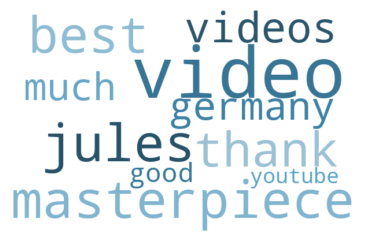

In [111]:
generate_wordcloud(results['positive'])

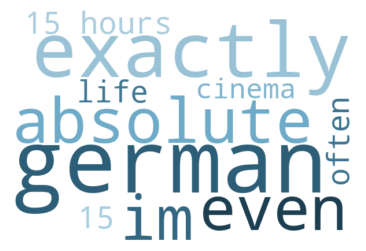

In [112]:
generate_wordcloud(results['negative'])